In [3]:
import os
import numpy as np
import pysindy as ps
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [7]:
# Amount of networks to generate
nets = 10

# Generation Options
nodes = 10000
edges = 2

# Networks
graphs = []

for net in range(nets):
    G = nx.generators.random_graphs.barabasi_albert_graph(nodes, edges)
    graphs += [G]

In [8]:
# Get average degree
avg_degree = np.zeros((nodes, nodes))
for idx, G in enumerate(graphs):
    print('Graph', idx)
    # Degrees through time
    degrees_t = np.zeros((nodes, nodes))
    for num, t in tqdm(enumerate(degrees_t)):
        index = range(num+1)
        H = G.subgraph(index)
        degrees_sub = np.fromiter(dict(nx.degree(H)).values(), dtype=int)
        degrees_t[num] = np.pad(degrees_sub, (0, nodes - num - 1), 'constant', constant_values=0)
    avg_degree += degrees_t
avg_degree /= nets

Graph 0


10000it [05:17, 31.52it/s]


Graph 1


10000it [05:17, 31.51it/s]


Graph 2


10000it [05:16, 31.61it/s]


Graph 3


10000it [05:16, 31.63it/s]


Graph 4


10000it [05:07, 32.51it/s]


Graph 5


10000it [05:04, 32.86it/s]


Graph 6


10000it [04:38, 35.90it/s]


Graph 7


10000it [04:30, 36.91it/s]


Graph 8


10000it [04:30, 36.97it/s]


Graph 9


10000it [04:29, 37.14it/s]


In [10]:
# Get File Names
data_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
save_path = os.path.join(data_path, 'Test_Network.npy')

with open(save_path, 'wb') as f:
    np.save(f, avg_degree)

In [113]:
t = np.arange(nodes)
avg_degree[:,0]

array([  0.,   1.,   2., ..., 203., 203., 203.])

# Model Structure
The sparse recovery of the dynamics depend on the model defined for it. Such model is composed of a differentiation method to find the numerical derivative of the measured data, a features library that contains the set of basis functions that define the likely behaviour of the data, and an optimizer that defines the algorithms that performs the sparse regression to solve the approximation problem. With this context and following [Tips](https://pysindy.readthedocs.io/en/latest/tips.html) the following is chosen:

## Differentiation Method
Based on [Differentiation](https://pysindy.readthedocs.io/en/latest/examples/5_differentation.html), there are different available methods to compute:

![X \rightarrow  \dot{X}](https://latex.codecogs.com/svg.latex?X&space;\rightarrow&space;\dot{X})

Given the stepwise nature of the degree of a node in the network, since it grows in discrete amplitudes on discrete time, the Trend Filtered method was chose.

**TODO:**
- [ ] PySINDy Finite Difference: Forward & Centered
- [ ] Finite Difference
- [ ] Smoothed Finite Difference
- [ ] Savitzky Golay
- [ ] Spline
- [x] Trend Filtered
- [ ] Spectral

## Basis Set
SINDy assumes that the system dynamics can be represented as a sparse linear combination of the basis functions. A bad selection of a basis set leads to the assumption being violated and as such a resulting bad model (generally non-sparse). Based on this an ideal approach would be a basis set of functions that defines the likely nature; in this case some time-series basis set would be ideal. As an initial approach the Polynomial Library is used since such basis set requieres deeper insight into the data.

## Optimizer
For the optimizer an initial attempt with the sequentially-thresholded least-squares algorithm is simpler and future attempts with other methods (such as LASSO) can be done as a comparison.

In [127]:
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(kind='trend_filtered', order=0, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=3),
    optimizer=ps.STLSQ(threshold=0.00001),
    feature_names=['K', 't']
)

In [129]:
# First column is the degree the second one is the time
# X = avg_degree[:,0]
X = np.stack((avg_degree[:,0], t[:]), axis=-1)
model.fit(X)

/local/anaconda3/envs/dddu/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.73539e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/local/anaconda3/envs/dddu/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.73539e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


SINDy(differentiation_method=SINDyDerivative(alpha=0.01, kind='trend_filtered',
                                             order=0),
      feature_library=PolynomialLibrary(degree=3), feature_names=['K', 't'],
      optimizer=STLSQ(threshold=1e-05))

In [130]:
model.print()

K' = 0.128 1 + -0.002 K
t' = 1.000 1


In [131]:
# Get vectors for plotting
k_mod = avg_degree[:,0]
k_sim = model.simulate([0,0], t=t)[:,0]

In [140]:
# Analytic approach
def barabasi(k, t):
    return k / (2*t)

T = 10000
k_ant = np.zeros(T)
k_ant[1:10] = k_mod[1:10]

for t_a in range(1, T-1):
        dk = barabasi(k_ant[t_a], t_a)
        k_ant[t_a + 1] = k_ant[t_a] + dk

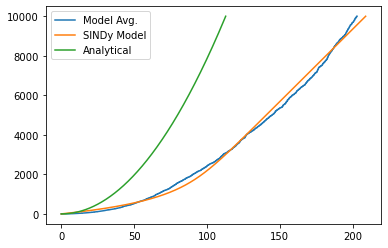

In [141]:
plt.plot(t, k_mod)
plt.plot(t, k_sim)
plt.plot(t, k_ant)
plt.legend(['Model Avg.', 'SINDy Model', 'Analytical'])